# China Projects: Food waste treatment and co-digestion

In [241]:
library(Benchmarking)
library(ggplot2)
library(tidyverse)
library(GGally)
library(mice)
library(VIM)
library(reshape2)
library(gridExtra)
library(missForest)
library(rpart)
library(randomForest)
library(caret)

## 1. Data preparation, imputation, and vizualization

#### Data cleaning and imputation

In [42]:
# Read in data
df <- read.csv("DataDEA2.csv")

In [242]:
# Change variable types (numeric or factor)
df$Total_Investment_RMB <- as.numeric(df$Total_Investment_RMB)
df$Total_Input_t.d <- as.numeric(df$Total_Input_t.d)
df$DigestedWaste <- as.factor(df$DigestedWaste)
df$Codigestion. <- as.factor(df$Codigestion.)
df$RawBiogas_m3.d <- as.numeric(df$RawBiogas_m3.d)
df$All.outputs..inc.biogas <- as.factor(df$All.outputs..inc.biogas)
df$Biogas.upgrading. <- as.factor(df$Biogas.upgrading.)
df$Pretreatment <- as.factor(df$Pretreatment)

In [243]:
# Keep relevant variables in a new data frame
df2 <- df[c('Total_Investment_RMB','Total_Input_t.d',
                 'DigestedWaste','Codigestion.',
                'RawBiogas_m3.d', 'All.outputs..inc.biogas')]


 Variables sorted by number of missings: 
                Variable      Count
          RawBiogas_m3.d 0.43564356
 All.outputs..inc.biogas 0.25742574
    Total_Investment_RMB 0.02970297
         Total_Input_t.d 0.00000000
           DigestedWaste 0.00000000
            Codigestion. 0.00000000


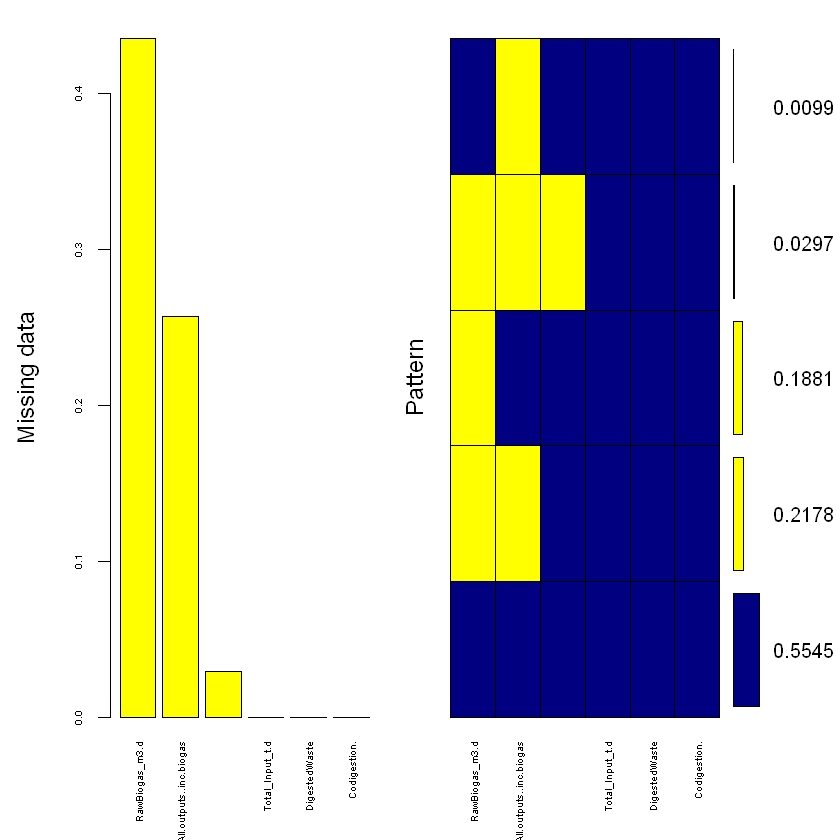

In [244]:
# Test for missing values and visualize  
missVals_plot <- aggr(df_pairs, col=c('navyblue','yellow'),
                    numbers=TRUE, sortVars=TRUE,
                    labels=names(df_pairs), cex.axis=.5,
                    gap=3, ylab=c("Missing data","Pattern"))

In [245]:
# Imputation of missing values with random forest
df_rfImp <- missForest(df2)
df2 <- df_rfImp$ximp

  missForest iteration 1 in progress...done!
  missForest iteration 2 in progress...done!
  missForest iteration 3 in progress...done!
  missForest iteration 4 in progress...done!
  missForest iteration 5 in progress...done!
  missForest iteration 6 in progress...done!
  missForest iteration 7 in progress...done!
  missForest iteration 8 in progress...done!
  missForest iteration 9 in progress...done!


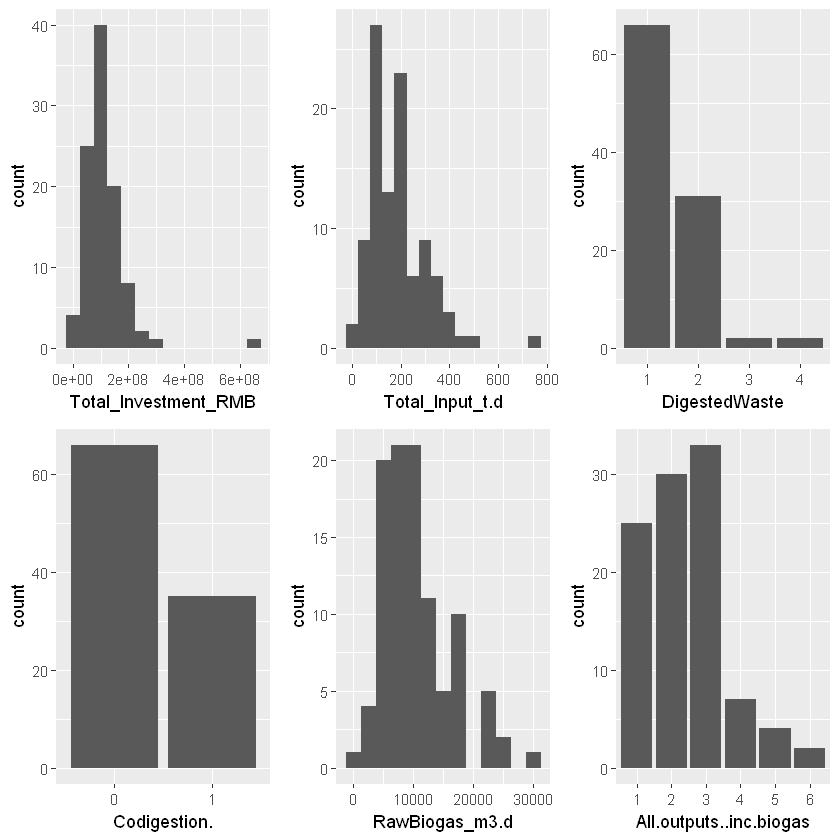

In [246]:
# Visualize the distributions of our variables
h1 <- ggplot(data = df2, aes(x = Total_Investment_RMB)) + geom_histogram(binwidth=50000000)
h2 <- ggplot(data = df2, aes(x = Total_Input_t.d)) + geom_histogram(binwidth=50)
h3 <- ggplot(data = df2, aes(x = DigestedWaste)) + geom_bar()
h4 <- ggplot(data = df2, aes(x = Codigestion.)) + geom_bar()
h5 <- ggplot(data = df2, aes(x = RawBiogas_m3.d)) + geom_histogram(binwidth=2500)
h6 <- ggplot(data = df2, aes(x = All.outputs..inc.biogas)) + geom_bar()

# Place the plot objects into a grid
grid.arrange(h1,h2,h3,h4,h5,h6,ncol=3)

`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.
`stat_bin()` using `bins = 30`. Pick better value with `binwidth`.


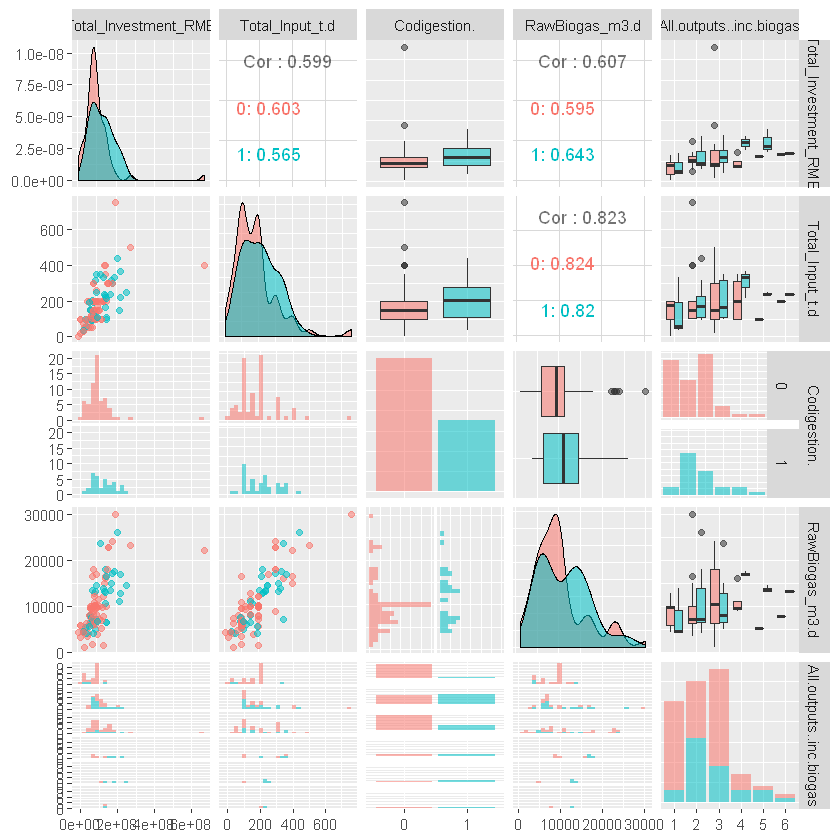

In [247]:
# Pairplot of selected variables:
ggpairs(df2[-3], aes(colour = Codigestion., alpha = 0.4))

## 2. Machine learning

In [248]:
# Set caret theme
trellis.par.set(caretTheme())

In [249]:
# We will use repeated cross-validation
fitControl <- trainControl(## 10-fold CV
                           method = "repeatedcv",
                           number = 10,
                           repeats = 10)

### Random Forest model

In [252]:
# We first train a random forest model
set.seed(0)
rf_mod <- train(RawBiogas_m3.d ~ ., data = df2, 
                 method = "rf", 
                 trControl = fitControl,
                 tuneLength = 8)

In [255]:
# Model performance summary
rf_mod

Random Forest 

101 samples
  5 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 93, 90, 90, 91, 91, 92, ... 
Resampling results across tuning parameters:

  mtry  RMSE      Rsquared   MAE     
   2    3458.976  0.7267766  2538.690
   3    3128.364  0.7382004  2152.225
   4    3052.943  0.7377789  2035.882
   5    3048.852  0.7332282  2006.446
   7    3058.656  0.7318781  2034.774
   8    3081.729  0.7287790  2059.490
   9    3096.733  0.7284528  2078.064
  11    3167.717  0.7197436  2138.340

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 5.

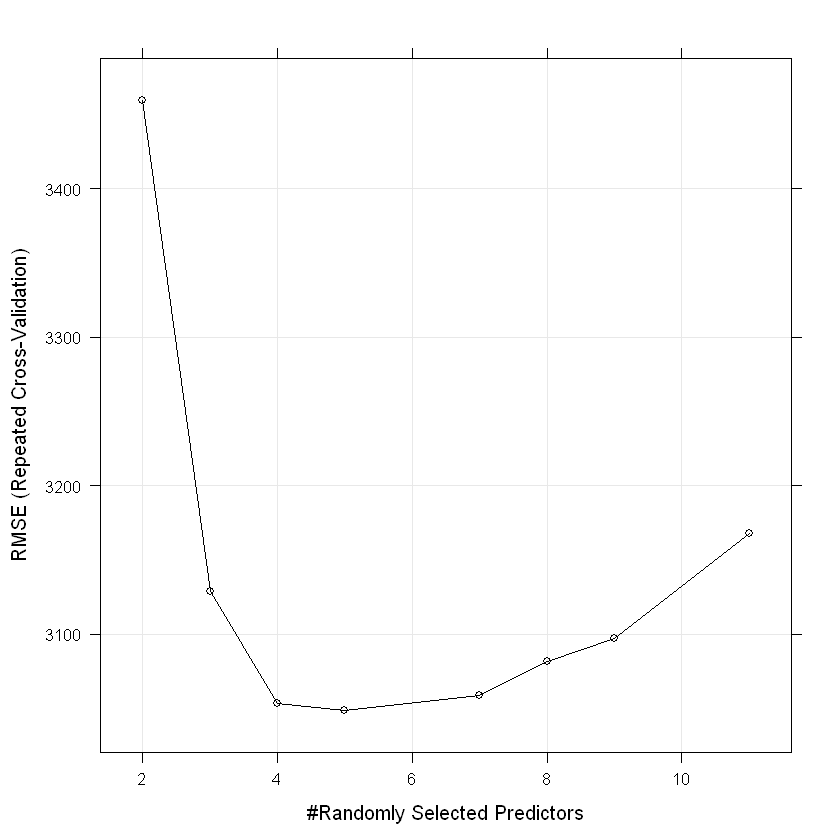

In [266]:
# Plot model training resutls
plot(rf_mod)

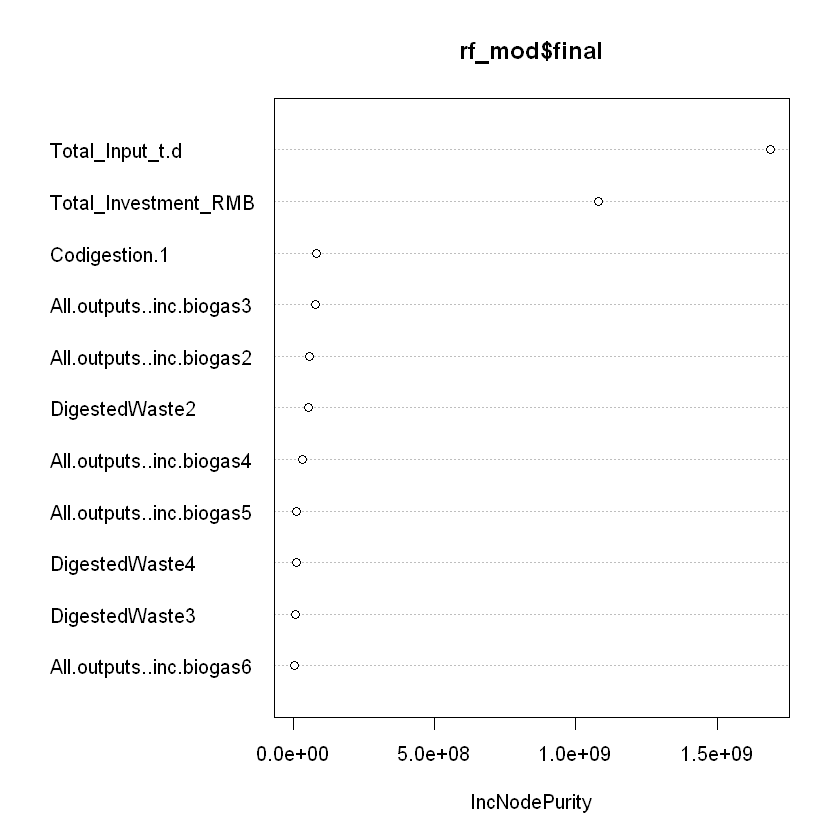

In [258]:
# Variable importance plot
varImpPlot(rf_mod$final)

### Gradient boosted machine model

In [261]:
# Next, we train a gbm model
set.seed(0)
gbm_mod <- train(RawBiogas_m3.d ~ ., data = df2, 
                 method = "gbm", 
                 trControl = fitControl,
                 tuneLength = 8)

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 31007680.1843             nan     0.1000 3870619.2636
     2 28307352.8568             nan     0.1000 1804481.6942
     3 24711949.3779             nan     0.1000 2733563.9162
     4 22283964.6032             nan     0.1000 1776187.2876
     5 20678209.4147             nan     0.1000 1925860.5736
     6 19539643.4478             nan     0.1000 752613.7116
     7 17956398.8366             nan     0.1000 1207465.6107
     8 16786077.8471             nan     0.1000 789407.5298
     9 15892464.4334             nan     0.1000 838188.8803
    10 15033900.9587             nan     0.1000 529101.6254
    20 10948345.6180             nan     0.1000 97998.5661
    40  8951040.7237             nan     0.1000 -9523.1405
    60  8599033.8364             nan     0.1000 -145384.2185
    80  8299622.9495             nan     0.1000 -3943.5089
   100  8046731.9109             nan     0.1000 -92148.1554
   120  7784569.9057             nan  

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 5: DigestedWaste4 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 30429877.8112             nan     0.1000 3981000.3077
     2 27371066.4649             nan     0.1000 3285642.8229
     3 24908374.1010             nan     0.1000 2400502.5423
     4 23463515.2006             nan     0.1000 1813920.1056
     5 21999847.4863             nan     0.1000 1104543.1677
     6 20132988.0014             nan     0.1000 1361663.4961
     7 18667816.0417             nan     0.1000 901992.6900
     8 17488858.0865             nan     0.1000 969682.5115
     9 16307943.9044             nan     0.1000 534686.8188
    10 15325604.8777             nan     0.1000 519067.1750
    20 11324653.5775             nan     0.1000 149385.6581
    40  9380704.2402             nan     0.1000 -19183.2367
    60  8873433.9018             nan     0.1000 -51820.4800
    80  8515037.6686             nan     0.1000 -175916.6033
   100  8380383.9967             nan     0.1000 -55970.3107
   120  8002360.2937             na

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 5: DigestedWaste4 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 31226009.9387             nan     0.1000 4295348.9851
     2 27302545.8643             nan     0.1000 3382813.0197
     3 25089052.9017             nan     0.1000 1938617.5849
     4 23060332.0879             nan     0.1000 1613406.8554
     5 20809338.9103             nan     0.1000 2162798.2314
     6 19495982.6510             nan     0.1000 1340840.1892
     7 18007264.5793             nan     0.1000 1248032.7510
     8 16937784.3619             nan     0.1000 1223507.2699
     9 16244245.3409             nan     0.1000 913386.6023
    10 15186190.4398             nan     0.1000 967901.9649
    20 10791261.8152             nan     0.1000 -365182.0763
    40  8602559.4714             nan     0.1000 -93189.0878
    60  7730449.8482             nan     0.1000 -12358.3321
    80  7184016.4881             nan     0.1000 -138158.0571
   100  6838700.4014             nan     0.1000 -49888.2408
   120  6466087.4681            

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 5: DigestedWaste4 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 30721770.7233             nan     0.1000 3863058.4880
     2 27054540.9645             nan     0.1000 3290348.2835
     3 23781382.2449             nan     0.1000 2057843.4136
     4 21229417.5489             nan     0.1000 1164621.7028
     5 19423988.6679             nan     0.1000 1843003.7846
     6 17920423.2626             nan     0.1000 1458653.6249
     7 16351596.6905             nan     0.1000 1135607.6147
     8 15257597.9887             nan     0.1000 758293.5667
     9 14331622.9788             nan     0.1000 611513.2277
    10 13505153.9893             nan     0.1000 610859.3135
    20 10064269.0216             nan     0.1000 84345.7381
    40  8060882.6449             nan     0.1000  563.1802
    60  7311631.9114             nan     0.1000 -178114.5875
    80  6855505.1716             nan     0.1000 -164615.5461
   100  6389472.9646             nan     0.1000 -179649.0245
   120  5953066.3860             na

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 5: DigestedWaste4 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 30250970.7669             nan     0.1000 3941682.4642
     2 26603346.7493             nan     0.1000 3452996.8664
     3 23504254.5439             nan     0.1000 2166003.5059
     4 21761641.5717             nan     0.1000 1966435.2780
     5 19761402.9432             nan     0.1000 1720555.5058
     6 18003272.5887             nan     0.1000 1040821.0005
     7 16645156.6251             nan     0.1000 1216735.1739
     8 15360176.9486             nan     0.1000 765493.5227
     9 14387443.2432             nan     0.1000 623129.6904
    10 13608305.4036             nan     0.1000 615097.5476
    20 10028223.9072             nan     0.1000 182520.6739
    40  8044374.6261             nan     0.1000 -178406.0941
    60  7239432.9058             nan     0.1000 -63430.2028
    80  6570889.2895             nan     0.1000 -58913.7573
   100  6232637.3228             nan     0.1000 -156307.8398
   120  5943441.4070             

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 5: DigestedWaste4 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 31358645.7789             nan     0.1000 2736400.9803
     2 27637072.8470             nan     0.1000 3200171.0731
     3 24896810.6685             nan     0.1000 2259210.9649
     4 22303630.2085             nan     0.1000 2643855.8716
     5 20460530.0794             nan     0.1000 2218397.0786
     6 18355113.0585             nan     0.1000 1621378.6267
     7 16790912.9151             nan     0.1000 1102040.1688
     8 15508803.9771             nan     0.1000 911697.8351
     9 14497918.5269             nan     0.1000 941921.9167
    10 13750366.1164             nan     0.1000 674511.8044
    20  9873541.3004             nan     0.1000 -55957.8679
    40  8103320.0475             nan     0.1000 -122592.6994
    60  7454608.4134             nan     0.1000 -145263.0510
    80  7094060.5937             nan     0.1000 -166056.2050
   100  6598207.2335             nan     0.1000 -107427.6182
   120  6201741.5100           

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 5: DigestedWaste4 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 31107021.3272             nan     0.1000 3926227.5647
     2 27513566.9827             nan     0.1000 3560459.3906
     3 24463887.7466             nan     0.1000 3053021.9529
     4 22547601.1681             nan     0.1000 2268513.3250
     5 20206798.1496             nan     0.1000 2146809.5984
     6 18505492.4591             nan     0.1000 1690406.0196
     7 17411488.8647             nan     0.1000 1164018.1338
     8 16503398.7989             nan     0.1000 836386.5977
     9 15306876.7666             nan     0.1000 607403.0378
    10 13978447.8944             nan     0.1000 659755.7690
    20 10309607.2663             nan     0.1000 131506.2869
    40  8183212.6385             nan     0.1000 -73824.2244
    60  7281480.1307             nan     0.1000 -127791.0296
    80  6836431.8361             nan     0.1000 -43064.2510
   100  6343941.6739             nan     0.1000 -57881.8239
   120  6012360.1897             n

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 5: DigestedWaste4 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 30834178.6087             nan     0.1000 4018049.2379
     2 26608316.3101             nan     0.1000 3332593.2416
     3 23466560.9760             nan     0.1000 2183563.9627
     4 21653128.7246             nan     0.1000 1747955.7735
     5 19750980.5884             nan     0.1000 1826043.7837
     6 18462311.0067             nan     0.1000 1452728.9419
     7 17122733.9350             nan     0.1000 1063894.5050
     8 16103382.8547             nan     0.1000 944480.6976
     9 14970481.3540             nan     0.1000 926131.3595
    10 14120412.4543             nan     0.1000 441900.9183
    20 10658383.1045             nan     0.1000 88903.1593
    40  8033387.8162             nan     0.1000 -101365.8735
    60  7215126.4626             nan     0.1000 -75135.7204
    80  6722344.9091             nan     0.1000 -50334.0709
   100  6319827.2926             nan     0.1000 -103418.2791
   120  5987953.4121             n

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 5: DigestedWaste4 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 30908264.3635             nan     0.1000 4370524.0524
     2 27353641.1588             nan     0.1000 3425177.0732
     3 24337851.5728             nan     0.1000 2543470.5558
     4 21962789.7034             nan     0.1000 1922711.5523
     5 19840578.8536             nan     0.1000 1393249.5646
     6 18090722.7964             nan     0.1000 1609502.3045
     7 16636501.4529             nan     0.1000 1502042.3865
     8 15579679.2174             nan     0.1000 995980.3467
     9 14587908.3330             nan     0.1000 871083.2255
    10 13824633.3621             nan     0.1000 525805.3777
    20 10126297.2104             nan     0.1000 81400.0107
    40  8147134.5726             nan     0.1000 -108268.2299
    60  7560109.2727             nan     0.1000 -6487.3049
    80  7103017.2963             nan     0.1000 -66003.4849
   100  6720665.9667             nan     0.1000 -149409.9840
   120  6367620.7646             na

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: All.outputs..inc.biogas6 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 29297484.5905             nan     0.1000 3405175.2443
     2 26261706.1030             nan     0.1000 2273445.7779
     3 23581984.6107             nan     0.1000 2033708.7659
     4 21826157.6905             nan     0.1000 1750624.0402
     5 20493364.7223             nan     0.1000 1284880.3362
     6 18755185.3145             nan     0.1000 553745.3415
     7 17660897.9114             nan     0.1000 881798.8476
     8 16746944.1688             nan     0.1000 927897.0676
     9 15962494.6051             nan     0.1000 763922.9857
    10 15271482.2764             nan     0.1000 669162.5112
    20 11222532.6099             nan     0.1000 203218.8057
    40  9382578.5482             nan     0.1000 -161583.8841
    60  8916061.4912             nan     0.1000 -19045.3304
    80  8463640.3459             nan     0.1000 -4545.5240
   100  8184989.2515             nan     0.1000 -59700.1254
   120  7952367.5357             nan 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: All.outputs..inc.biogas6 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 29507473.2197             nan     0.1000 3919371.5530
     2 26329493.7742             nan     0.1000 2471791.1111
     3 23564070.2854             nan     0.1000 2362755.7895
     4 20930639.6496             nan     0.1000 2194311.5999
     5 18950501.2275             nan     0.1000 1796613.3162
     6 17973157.8285             nan     0.1000 1171538.8770
     7 16829312.1479             nan     0.1000 1322883.8337
     8 16166741.8097             nan     0.1000 614366.4570
     9 15081232.9490             nan     0.1000 831902.5893
    10 14420343.1636             nan     0.1000 829408.7084
    20 10306211.9774             nan     0.1000 -73302.8524
    40  8588080.2373             nan     0.1000 -20673.6037
    60  7777452.0163             nan     0.1000 -23733.0255
    80  7041323.1198             nan     0.1000 -126919.6996
   100  6652522.2050             nan     0.1000 -136037.1851
   120  6279169.7558             

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: All.outputs..inc.biogas6 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 29361265.1449             nan     0.1000 3697337.7373
     2 25463975.2167             nan     0.1000 3713470.5301
     3 22412407.5384             nan     0.1000 1804867.0359
     4 20301447.3664             nan     0.1000 1448339.9598
     5 18511318.8273             nan     0.1000 1880464.5431
     6 17019313.1125             nan     0.1000 1315734.0748
     7 15480516.7119             nan     0.1000 656484.6903
     8 14578546.2564             nan     0.1000 608570.2634
     9 13885534.0881             nan     0.1000 733348.9208
    10 13251976.7955             nan     0.1000 438845.3514
    20 10028368.7609             nan     0.1000 -80970.4467
    40  7955302.1501             nan     0.1000 -45077.4412
    60  7426446.4099             nan     0.1000 -230512.0302
    80  6956271.7439             nan     0.1000 -92474.2278
   100  6494314.9793             nan     0.1000 -182018.5120
   120  5892260.5809             n

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: All.outputs..inc.biogas6 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 29070308.1021             nan     0.1000 3746644.5736
     2 26577816.1806             nan     0.1000 3010862.9796
     3 24120200.7331             nan     0.1000 2653999.6134
     4 22042448.7936             nan     0.1000 1875170.3056
     5 19967680.7898             nan     0.1000 1710935.2440
     6 18104108.0208             nan     0.1000 1134567.3105
     7 17331731.3882             nan     0.1000 877250.9342
     8 15984952.4527             nan     0.1000 1050580.1565
     9 14806447.8245             nan     0.1000 639048.6914
    10 13951515.4900             nan     0.1000 536574.4796
    20  9978792.0334             nan     0.1000 153260.2102
    40  8233658.6592             nan     0.1000 -73490.7856
    60  7108903.1455             nan     0.1000 -214800.6549
    80  6491837.2064             nan     0.1000 -97091.8999
   100  6133747.8530             nan     0.1000 -99155.1013
   120  5715879.3073             n

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: All.outputs..inc.biogas6 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 29548064.7812             nan     0.1000 3778163.5953
     2 25968896.1236             nan     0.1000 2825120.2769
     3 23681803.6927             nan     0.1000 1850095.8924
     4 21065715.7262             nan     0.1000 2320527.8576
     5 19161192.6287             nan     0.1000 1823406.1817
     6 17778573.4976             nan     0.1000 1559321.0138
     7 16303354.2234             nan     0.1000 1164166.0563
     8 15049739.7368             nan     0.1000 927034.4127
     9 14291982.1644             nan     0.1000 631530.0612
    10 13609006.1507             nan     0.1000 600109.6380
    20 10107346.3290             nan     0.1000 109998.9753
    40  8132803.5942             nan     0.1000 -78944.2933
    60  7656702.5332             nan     0.1000 -45802.8620
    80  6938554.8840             nan     0.1000 4775.6371
   100  6450403.3693             nan     0.1000 -75147.2392
   120  6065325.7253             nan 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: All.outputs..inc.biogas6 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 29539798.1576             nan     0.1000 4083620.9188
     2 26914422.4083             nan     0.1000 3165378.7978
     3 23645135.8976             nan     0.1000 2764052.5582
     4 21244552.6587             nan     0.1000 1697560.9486
     5 19345538.1162             nan     0.1000 1861037.5998
     6 18056657.0111             nan     0.1000 1518890.1602
     7 16652187.6847             nan     0.1000 1005946.6729
     8 15630290.6805             nan     0.1000 938693.2717
     9 14678153.4779             nan     0.1000 823616.8094
    10 13774295.2922             nan     0.1000 373105.9566
    20 10156099.5108             nan     0.1000 80865.8794
    40  8188578.4317             nan     0.1000 3823.3726
    60  7548379.6094             nan     0.1000 -63990.3738
    80  6832844.8559             nan     0.1000 -173593.7597
   100  6386765.7717             nan     0.1000 -49557.2119
   120  5904425.0736             nan 

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: All.outputs..inc.biogas6 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 29547388.6445             nan     0.1000 3920504.7169
     2 26736107.9931             nan     0.1000 2165212.1712
     3 24048708.3431             nan     0.1000 2533914.2277
     4 21632647.7473             nan     0.1000 1777382.8542
     5 19780526.2300             nan     0.1000 1001597.9048
     6 18031180.7916             nan     0.1000 1279765.5740
     7 16510465.4377             nan     0.1000 1110441.4890
     8 15173757.6870             nan     0.1000 1106711.9387
     9 14188864.5620             nan     0.1000 645384.9826
    10 13462659.7952             nan     0.1000 692519.1543
    20  9682196.5635             nan     0.1000 -61875.9501
    40  7980574.8403             nan     0.1000 -212861.9185
    60  7375889.7392             nan     0.1000 -379081.9764
    80  6733329.9464             nan     0.1000 -26152.0960
   100  6300466.7088             nan     0.1000 -121537.2221
   120  5972757.2511           

Warning message in (function (x, y, offset = NULL, misc = NULL, distribution = "bernoulli", :
"variable 11: All.outputs..inc.biogas6 has no variation."

Iter   TrainDeviance   ValidDeviance   StepSize   Improve
     1 29714434.6089             nan     0.1000 3934466.3777
     2 26420760.4065             nan     0.1000 3029230.7288
     3 23885493.4980             nan     0.1000 2594378.4420
     4 21772196.7086             nan     0.1000 2246264.2338
     5 19888636.3981             nan     0.1000 1825798.7471
     6 18387361.4021             nan     0.1000 1426121.0667
     7 16974451.8858             nan     0.1000 1038978.0913
     8 15933914.3903             nan     0.1000 797365.3603
     9 14807608.7360             nan     0.1000 1041563.2427
    10 13590686.7523             nan     0.1000 473418.4240
    20 10012831.8726             nan     0.1000 -106938.3024
    40  8319056.4774             nan     0.1000 -140824.5946
    60  7283679.2459             nan     0.1000 -83378.7138
    80  6746628.0327             nan     0.1000 -265767.5429
   100  6266992.4771             nan     0.1000 -57527.8560
   120  5826169.0463           

In [263]:
#Model performance summary
gbm_mod

Stochastic Gradient Boosting 

101 samples
  5 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 93, 90, 90, 91, 91, 92, ... 
Resampling results across tuning parameters:

  interaction.depth  n.trees  RMSE      Rsquared   MAE     
  1                   50      3255.353  0.7207772  2477.222
  1                  100      3251.038  0.7190503  2459.323
  1                  150      3264.033  0.7155334  2461.884
  1                  200      3281.252  0.7117244  2473.916
  1                  250      3288.828  0.7111926  2474.513
  1                  300      3319.816  0.7060132  2494.319
  1                  350      3333.562  0.7036947  2516.953
  1                  400      3366.009  0.6989308  2539.248
  2                   50      3250.736  0.7217987  2438.979
  2                  100      3255.252  0.7184461  2412.722
  2                  150      3290.987  0.7115296  2448.051
  2                  200      3332.195  0.7026

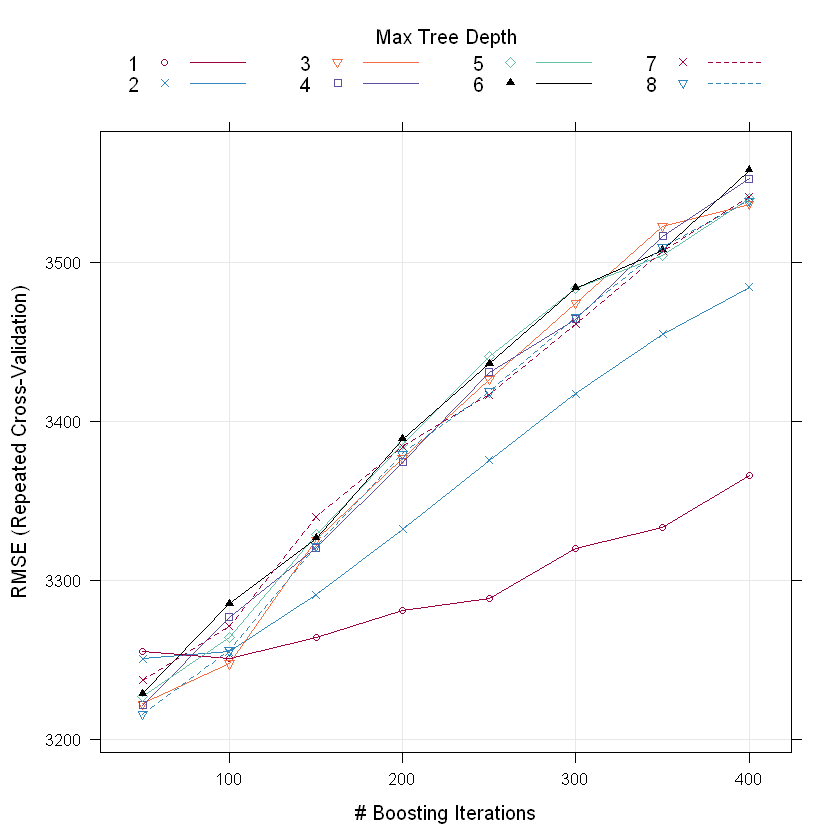

In [265]:
# Model training performance plot
plot(gbm_mod)

## 3. DEA on Chinese projects

In [97]:
# Create a new dataframe for the DEA and assign x and y variable values
x <- matrix(df2$Total_Investment_RMB)
y <- matrix(df2$RawBiogas_m3.d)

In [267]:
# Run the DEA model (one input, one output, input-oriented)
e_vrs <- dea(x,y, RTS="vrs", ORIENTATION = "in")

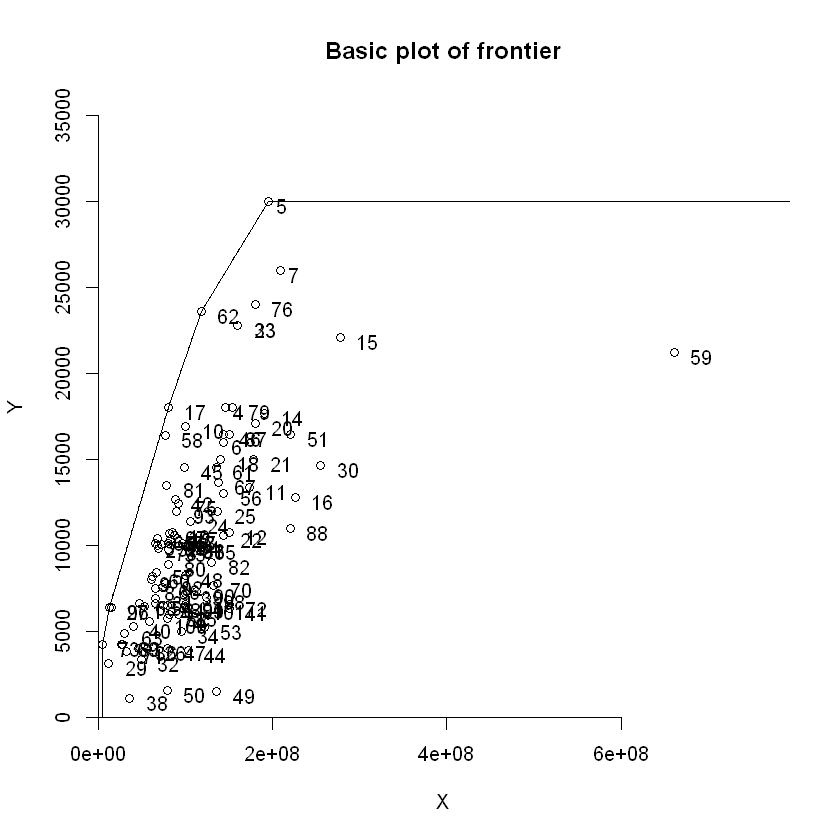

In [268]:
# Plot of different technologies with a title
dea.plot(x,y, txt=1:dim(x)[1],main="Basic plot of frontier")
dea.plot(x,y,RTS="vrs",add=TRUE,lty="dashed")

In [101]:
# e_vrs$lambda

# to do:
# Graphs of the outputs, peers, lambdas
# RF/DT/reg correlation of efficiency scores with other features

#### Plotting the isoquant for Chinese projects

In [270]:
# Prepare a new dataframe for the isoquant analysis
df_iso <- complete_df[c(1:2,5)]

# We need to convert the x values to per unit output
df_iso <- mutate(df_iso,
                unitInvestment = Total_Investment_RMB / Total_Input_t.d,
                unitInputCapacity = Total_Input_t.d / RawBiogas_m3.d,
                biogasOne = 1)

# Set up the variables x1 and x2
x1 <- matrix(df_iso$unitInvestment)
x2 <- matrix(df_iso$unitInputCapacity)

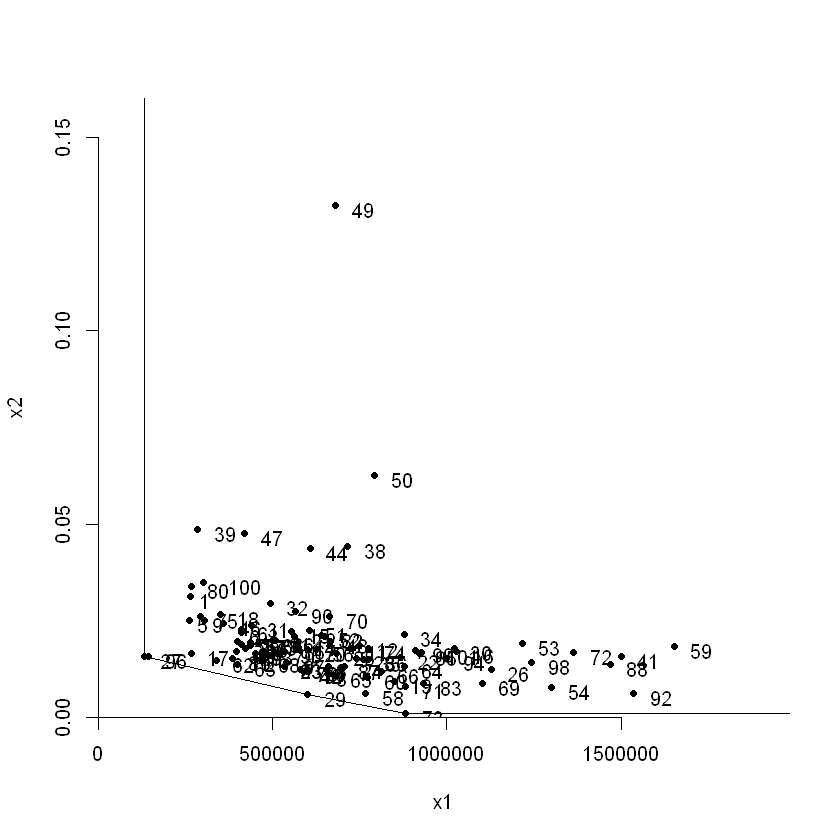

In [271]:
# Plot the isoquant
dea.plot.isoquant(x1,x2,txt=1:dim(x1)[1],pch=19,cex=0.8)

### Second stage of DEA: determinants of efficiency 

In [272]:
#First we build a new df for regressing features on efficiency values
df3 <- df2
df3$upgrading <- df$Biogas.upgrading.
eff <- e_vrs$eff
df3$eff <- eff
df3$unitInv <- df3$Total_Investment_RMB / df3$RawBiogas_m3.d
df3$unitInvCap <- df3$Total_Investment_RMB / df3$Total_Input_t.d

In [274]:
# Clean up the column names
colnames(df3) <- c("TotInvest","TotInput","CD_Amount","Codigestion","BiogasOutput","AllOutputs",
                   "Upgrading","eff","unitInv","unitInvCap")

In [282]:
# Efficiency model with cv and rf model
eff_mod_rf <- train(eff~ Codigestion + 
                     AllOutputs +  
                     unitInv + unitInvCap, 
                     data=df3,
                     method = "rf",
                     trControl = fitControl,
                     tuneLength = 8)

note: only 7 unique complexity parameters in default grid. Truncating the grid to 7 .



In [283]:
# Model performance summary
eff_mod_rf

Random Forest 

101 samples
  4 predictor

No pre-processing
Resampling: Cross-Validated (10 fold, repeated 10 times) 
Summary of sample sizes: 93, 90, 92, 91, 90, 91, ... 
Resampling results across tuning parameters:

  mtry  RMSE       Rsquared   MAE       
  2     0.1551577  0.6541764  0.11733984
  3     0.1415773  0.6859368  0.10370461
  4     0.1352547  0.7032947  0.09704293
  5     0.1327702  0.7062090  0.09463453
  6     0.1310152  0.7118530  0.09306771
  7     0.1305161  0.7118528  0.09236835
  8     0.1316621  0.7049760  0.09272537

RMSE was used to select the optimal model using the smallest value.
The final value used for the model was mtry = 7.

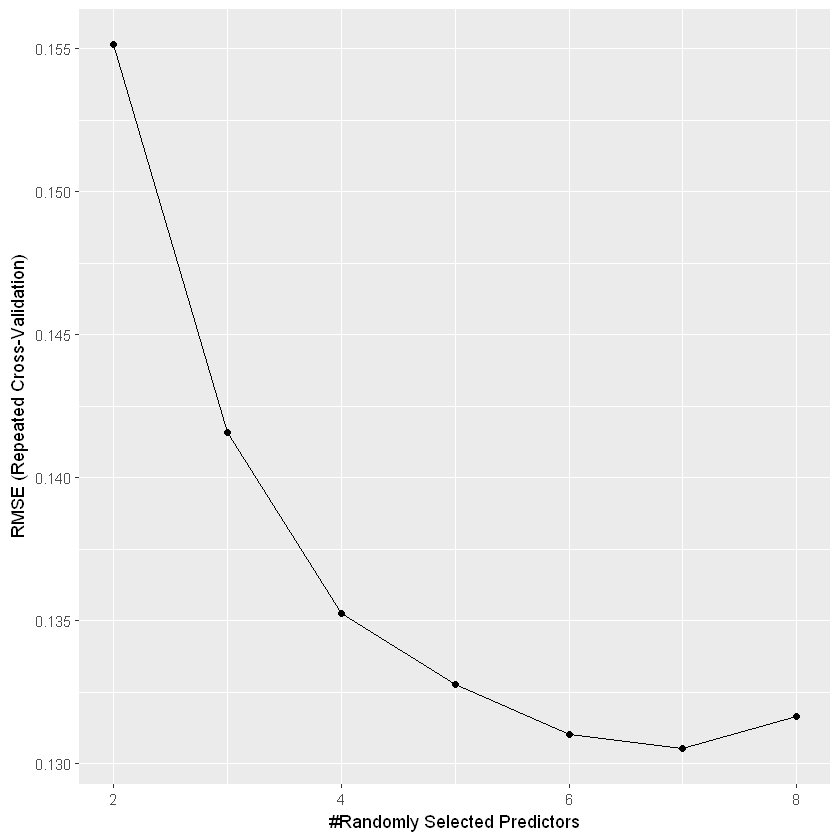

In [284]:
# Model training visualization
ggplot(eff_mod_rf)

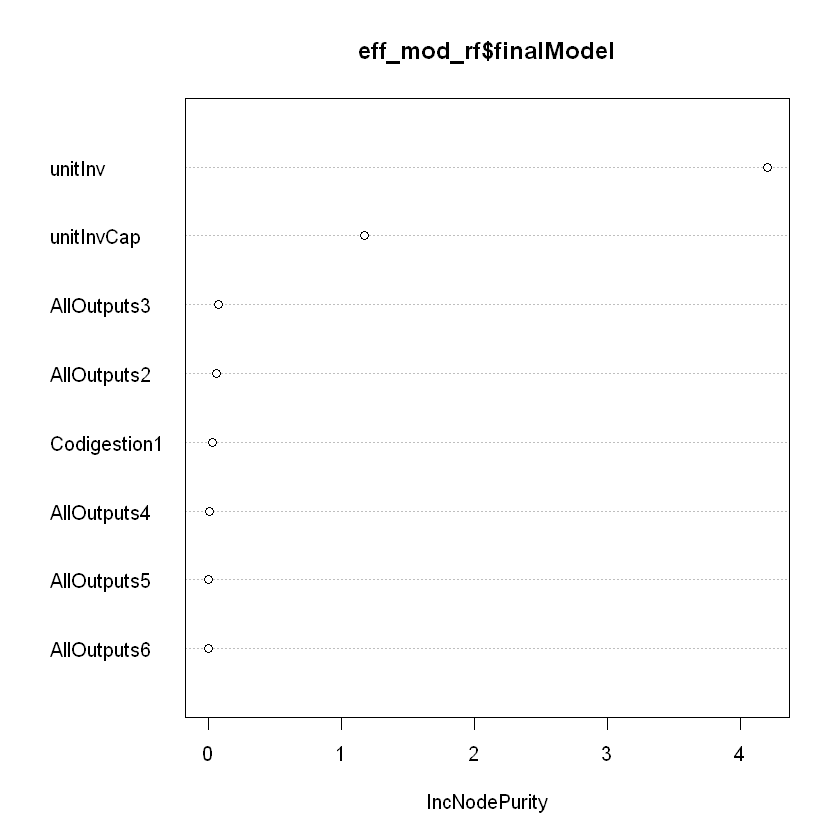

In [285]:
# Variable importance plot
varImpPlot(eff_mod_rf$finalModel)